In [193]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle as pkl
import random
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import tensorflow as tf
import keras
import keras_metrics as km
from sklearn.metrics import confusion_matrix

from keras.callbacks import TensorBoard
from keras import regularizers
from custom_callbacks import LrFinder
from custom_callbacks import CycleLearner
from custom_callbacks import reset_weights
from keras.callbacks import ModelCheckpoint
from time import time
from keras.layers import Input, Dense,Dropout,BatchNormalization,LSTM,GRU,Bidirectional,Conv2D, MaxPool2D, Flatten, GlobalAvgPool2D, GlobalMaxPool2D,merge
from keras.models import Model,Sequential
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.optimizers import Adagrad
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras import backend as K
import math
import json

# Get the dictionary containing each metric and the loss for each epoch


In [50]:
def get_log(name):
     return json.load(open(train_filepath + working_level + "/model_run_history/" + name + ".json", 'r'))

In [51]:
def save_log(log,name):
    log_dict = log.history    
    json.dump(log_dict, open(train_filepath + working_level + "/model_run_history/" + name + ".json", 'w'))

In [52]:
def generate_log_name(model_name,data_type,kmer,emb_type):
    return model_name + "-" + data_type + "-" + str(kmer) + "-" + emb_type

In [53]:
train_filepath = "train_workspace/"
animalList = ["Human","Pig","Chicken","Rat","Mouse","Dog"]
levelList = ["Strict","Relaxed","Intermediate"]
dataList = ["Ohnologs","No-Ohnologs","Paralogs"]
dataNameList = ["ohnologs","no-ohnologs","paralog"]


sns.set_style("darkgrid")

In [77]:
working_level = "Strict"
kmers = [3,8]
emb_types = ["normal","complete","cdna","cdna2"]
models_flat = ["Level","Flat_meta","Flat_complete"]
models = ["Flat","Level"]
datas = ["complete","diferential"]
levels = ["Strict","Intermediate"]
modelNames_Binary = ["Level_Paralogs_Binary","Siames_Binary"]
modelNames_Soft = ["Level_Paralogs_Softmax","Siames_Softmax"]
modelNames_RNN_Binary = ["Siames_Binary","Siames_Paralogs_RNN"]
modelNames_RNN_Soft = ["Siames_Softmax","Siames_Paralogs_RNN_Softmax"]

models_First = ["Level","Siames"]
models_Second = ["Siames","Siames RNN"]


In [8]:
log = get_log(generate_log_name("Siames_Binary","complete",8,"cdna"))
np.mean(log["val_main_acc"][-int(len(log["val_main_acc"])*0.2):])

0.8576087642652366

In [9]:
matrix_models_mean = np.ndarray(shape=(2,2))

In [10]:
matrix_models_std = np.ndarray(shape=(2,2))

In [147]:
df_temp = pd.DataFrame(columns = ["Model Name","Level","Precision"])            
df_temp.head()
matrix_models_mean_list = [[[] for i in range(2)] for i in range(2)]
matrix_models_mean_list
i = 0
for level in levels:    
    working_level = level
    j = 0
    for modelName in modelNames_Binary:       
        log = get_log(generate_log_name(modelName,"complete",8,"cdna"))  
        matrix_models_mean_list[i][j] = np.asarray(log["val_main_acc"][-int(len(log["val_main_acc"])*0.2):])
        matrix_models_mean_list[i][j] = np.asarray(log["val_main_acc"][-int(len(log["val_main_acc"])*0.2):])                        
        j +=1        
    i +=1

In [71]:
len(matrix_models_mean_list[0][1])

300

In [148]:
i = 0
model_name_list = []
level_list = []
values_list = []
for level in levels: 
    j = 0
    for modelName in models_First:       
        for k in range(0,300):
            model_name_list.append(modelName)
            level_list.append(level)           
            values_list.append(matrix_models_mean_list[i][j][k])                            
        j += 1    
    i += 1
    
df_temp["Model Name"] = model_name_list
df_temp["Level"] = level_list
df_temp["Precision"] = values_list
df_temp.head()

,Model Name,Level,Precision
0,Level,Strict,0.860940
1,Level,Strict,0.860465
2,Level,Strict,0.858804
3,Level,Strict,0.859041
4,Level,Strict,0.861414


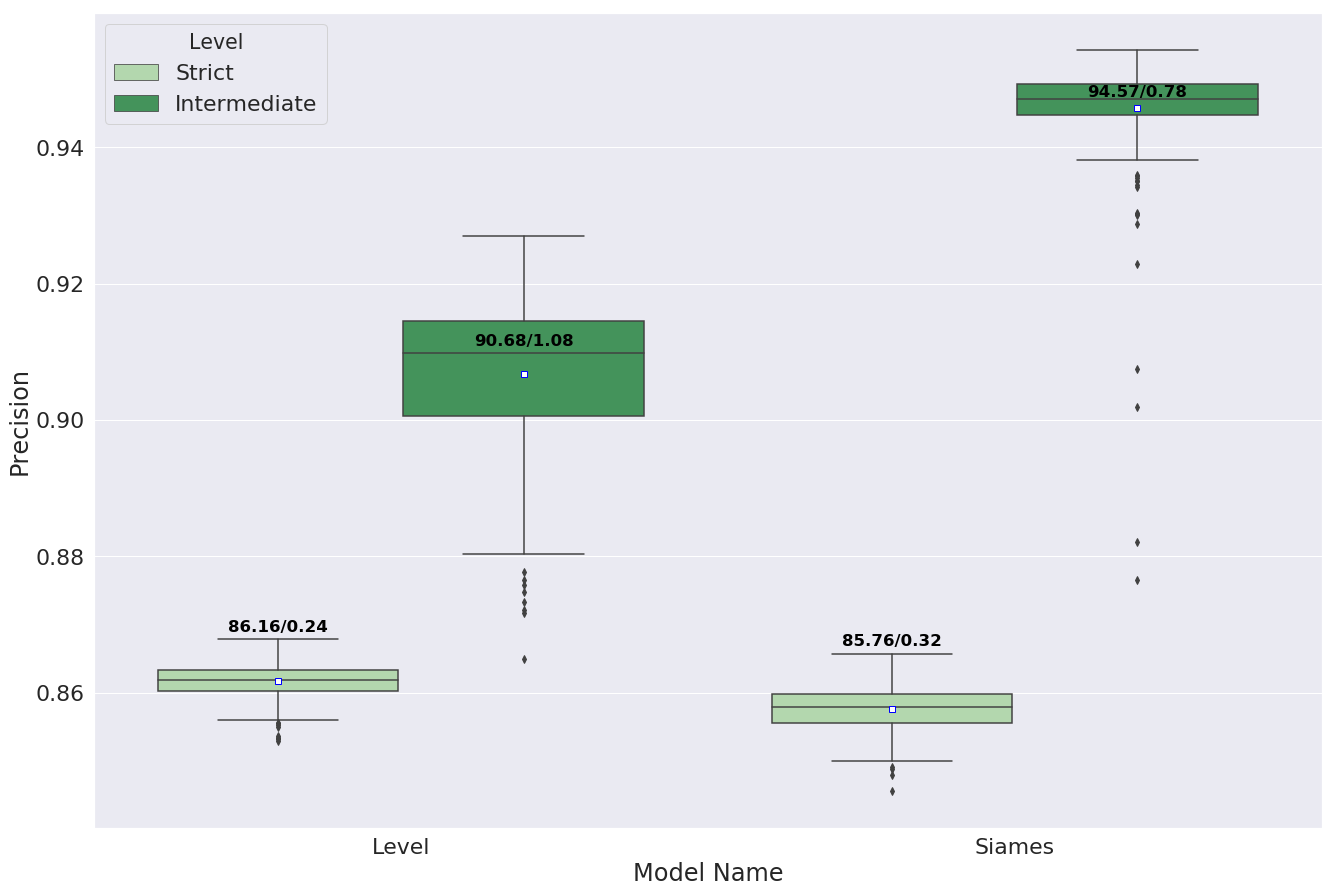

In [149]:
plt.subplots(figsize=(22,15))
ax = sns.boxplot("Model Name","Precision","Level",data=df_temp,showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"},palette="Greens")

std = df_temp.groupby(['Model Name',"Level"])['Precision'].std().values
mean = df_temp.groupby(['Model Name',"Level"])['Precision'].mean().values
median = df_temp.groupby(['Model Name',"Level"])['Precision'].median().values
labels = [str(np.round(m*100, 2)) + "/" + str(np.round(s*100, 2)) for (s,m) in zip(std,mean)]

pos = range(len(std))
for tick in pos:  
    if(tick % 2 == 0):
        if(tick == 0):
            ax.text(pos[tick]+ 0.2 - 0.5*pos[tick], median[tick]+0.001 , labels[tick], 
                horizontalalignment='center', size='x-small', color='black', weight='semibold')
        else:
            ax.text(pos[tick]+ 0.2 - 0.5*pos[tick], median[tick]+0.0003 , labels[tick], 
                horizontalalignment='center', size='x-small', color='black', weight='semibold')
        
    else:
        if(tick == 1):
            ax.text(pos[tick] - 0.7 - 0.5*pos[tick], median[tick]+0.007 , labels[tick], 
                horizontalalignment='center', size='x-small', color='black', weight='semibold')
        else:
            ax.text(pos[tick] - 0.7 - 0.5*pos[tick], median[tick]+0.009 , labels[tick], 
                horizontalalignment='center', size='x-small', color='black', weight='semibold')
                
fig = ax.get_figure()
fig.savefig("level_siames_binary_v2.png")

In [11]:
i = 0
for level in levels:    
    working_level = level
    j = 0
    for modelName in modelNames_Binary:
        log = get_log(generate_log_name(modelName,"complete",8,"cdna"))
        matrix_models_mean[i,j] = np.mean(log["val_main_acc"][-int(len(log["val_aux_acc"])*0.2):])              
        matrix_models_std[i,j] = np.std(log["val_main_acc"][-int(len(log["val_aux_acc"])*0.2):])  
        j +=1                       
    i +=1
matrix_models_mean

array([[0.86162791, 0.85760876],
       [0.90676726, 0.94574451]])

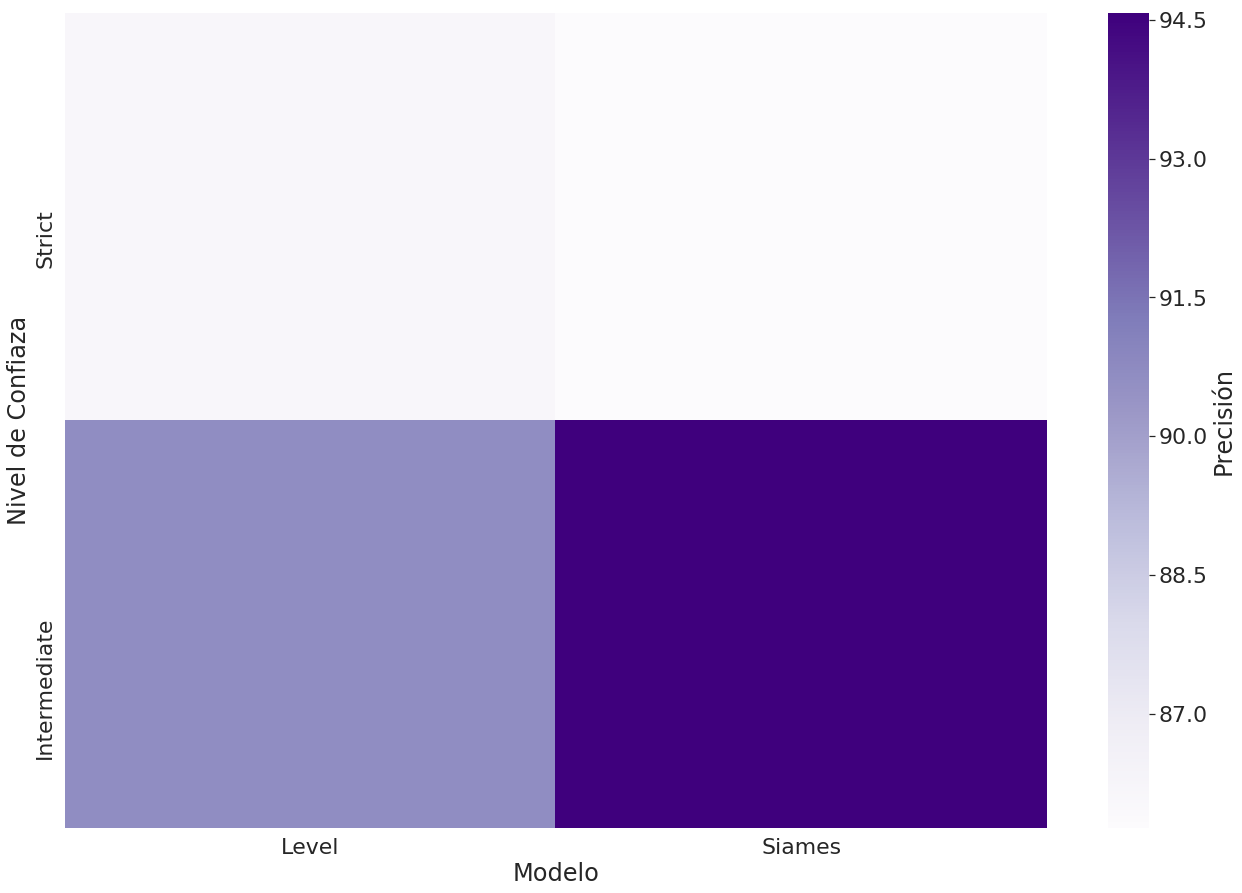

In [12]:
sns.set(font_scale=2)
plt.subplots(figsize=(22,15))
ax = sns.heatmap(matrix_models_mean*100,annot=False,fmt="f", cmap="Purples",square=False,xticklabels = ["Level","Siames"],yticklabels=["Strict","Intermediate"],cbar_kws={'label': 'Precisión'})
ax.set(ylabel='Nivel de Confiaza')
ax.set(xlabel='Modelo')
fig = ax.get_figure()
fig.savefig("paralogs_binary_precision2.png")

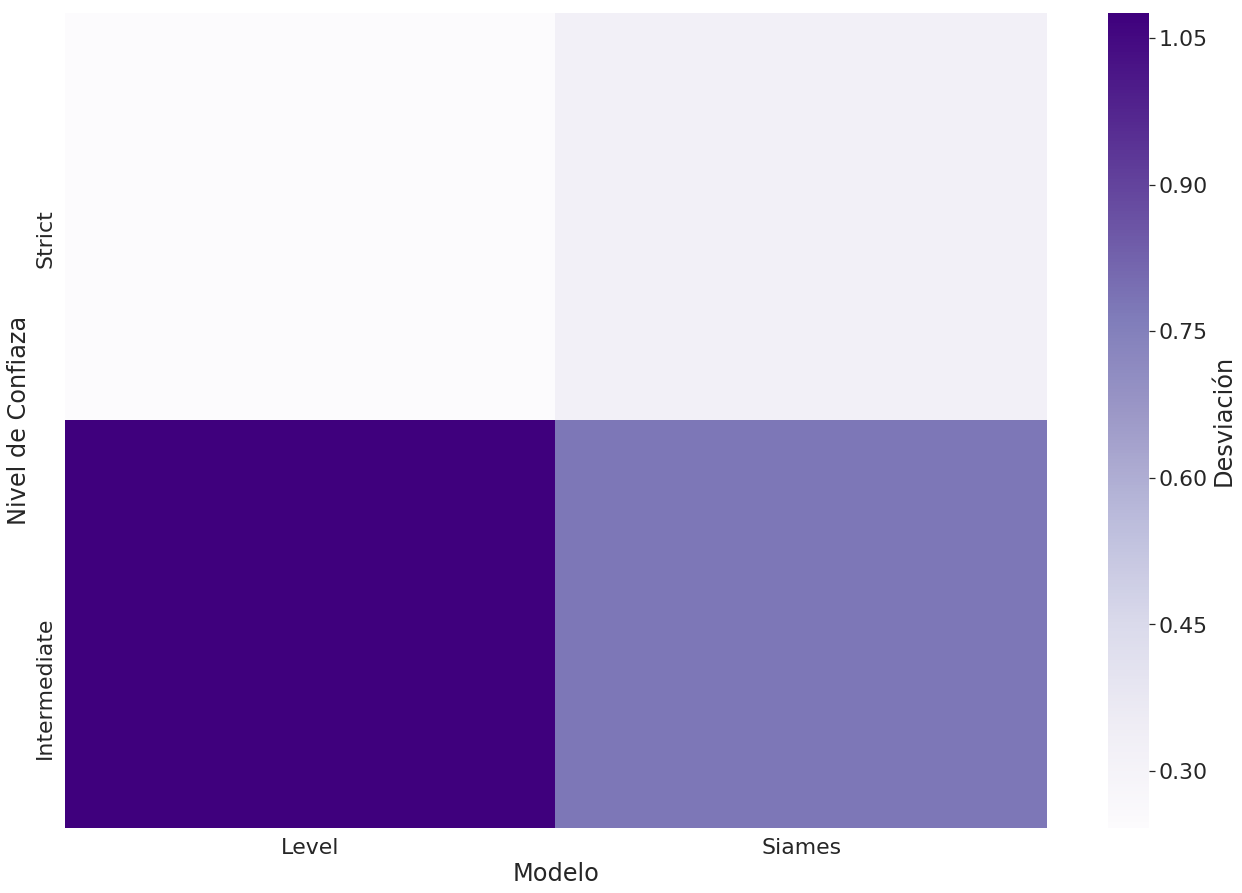

In [13]:
sns.set(font_scale=2)
plt.subplots(figsize=(22,15))
ax = sns.heatmap(matrix_models_std*100,annot=False,fmt="f", cmap="Purples",square=False,xticklabels = ["Level","Siames"],yticklabels=["Strict","Intermediate"],cbar_kws={'label': 'Desviación'})
ax.set(ylabel='Nivel de Confiaza')
ax.set(xlabel='Modelo')
fig = ax.get_figure()
fig.savefig("paralogs_binary_std2.png")

In [150]:
df_temp = pd.DataFrame(columns = ["Model Name","Level","Precision"])            
df_temp.head()
matrix_models_mean_list = [[[] for i in range(2)] for i in range(2)]
matrix_models_mean_list
i = 0
for level in levels:    
    working_level = level
    j = 0
    for modelName in modelNames_Soft:       
        log = get_log(generate_log_name(modelName,"complete",8,"cdna"))  
        matrix_models_mean_list[i][j] = np.asarray(log["val_main_acc"][-int(len(log["val_main_acc"])*0.2):])
        matrix_models_mean_list[i][j] = np.asarray(log["val_main_acc"][-int(len(log["val_main_acc"])*0.2):])                        
        j +=1        
    i +=1

In [151]:
i = 0
model_name_list = []
level_list = []
values_list = []
for level in levels: 
    j = 0
    for modelName in models_First:       
        for k in range(0,300):
            model_name_list.append(modelName)
            level_list.append(level)           
            values_list.append(matrix_models_mean_list[i][j][k])                            
        j += 1    
    i += 1
    
df_temp["Model Name"] = model_name_list
df_temp["Level"] = level_list
df_temp["Precision"] = values_list
df_temp.head()

,Model Name,Level,Precision
0,Level,Strict,0.796654
1,Level,Strict,0.791988
2,Level,Strict,0.794241
3,Level,Strict,0.790701
4,Level,Strict,0.794884


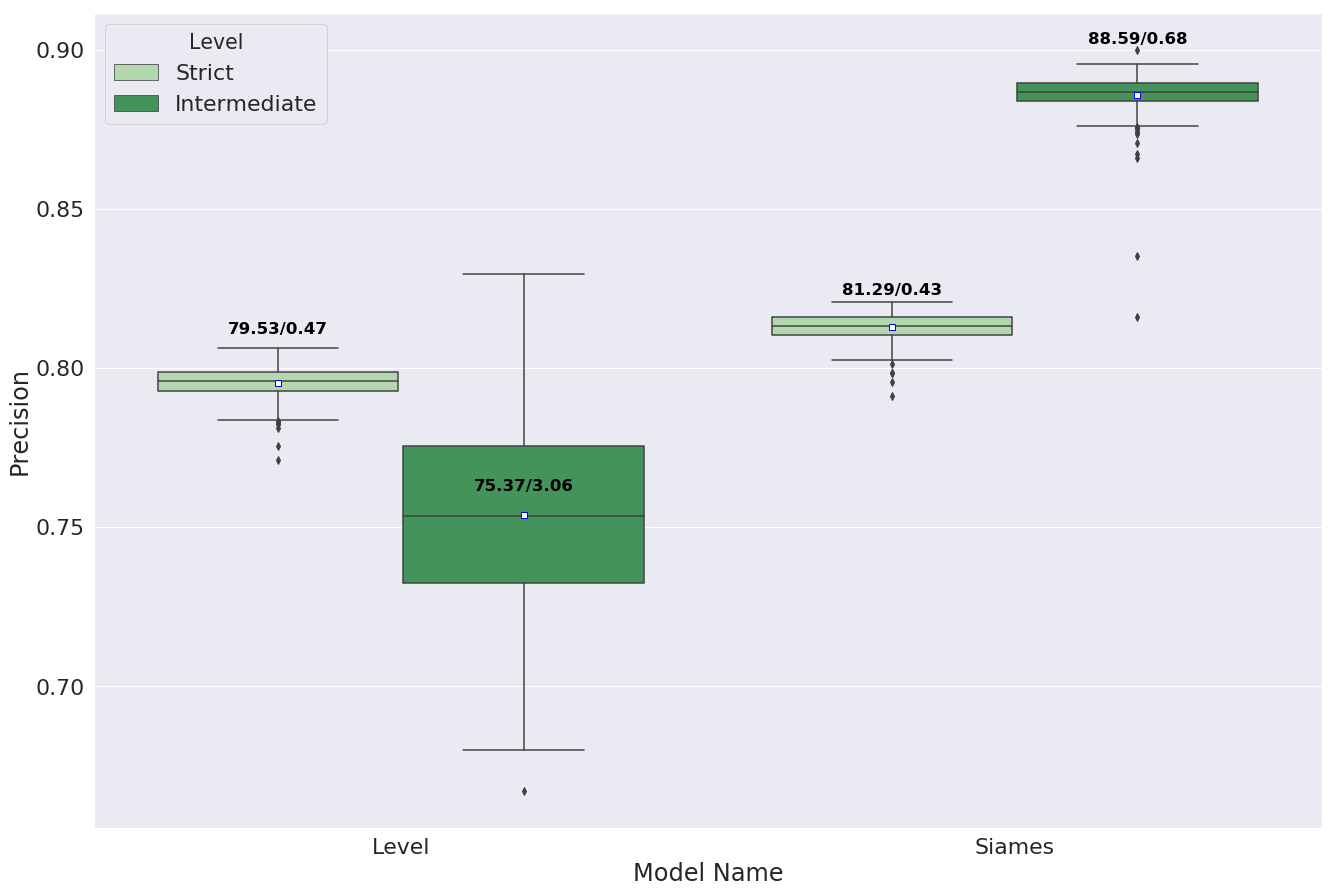

In [152]:
plt.subplots(figsize=(22,15))
ax = sns.boxplot("Model Name","Precision","Level",data=df_temp,showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"},palette="Greens")

std = df_temp.groupby(['Model Name',"Level"])['Precision'].std().values
mean = df_temp.groupby(['Model Name',"Level"])['Precision'].mean().values
median = df_temp.groupby(['Model Name',"Level"])['Precision'].median().values
labels = [str(np.round(m*100, 2)) + "/" + str(np.round(s*100, 2)) for (s,m) in zip(std,mean)]

pos = range(len(std))
for tick in pos:  
    if(tick % 2 == 0):
        if(tick == 0):
            ax.text(pos[tick]+ 0.2 - 0.5*pos[tick], median[tick]+0.008 , labels[tick], 
                horizontalalignment='center', size='x-small', color='black', weight='semibold')
        else:
            ax.text(pos[tick]+ 0.2 - 0.5*pos[tick], median[tick]+0.015, labels[tick], 
                horizontalalignment='center', size='x-small', color='black', weight='semibold')
        
    else:
        if(tick == 1):
            ax.text(pos[tick] - 0.7 - 0.5*pos[tick], median[tick]+0.015 , labels[tick], 
                horizontalalignment='center', size='x-small', color='black', weight='semibold')
        else:
            ax.text(pos[tick] - 0.7 - 0.5*pos[tick], median[tick]+0.01 , labels[tick], 
                horizontalalignment='center', size='x-small', color='black', weight='semibold')
fig = ax.get_figure()
fig.savefig("level_siames_soft_v2.png")

In [39]:
matrix_models_level_mean = np.ndarray(shape=(2,2))
matrix_models_level_std = np.ndarray(shape=(2,2))
i = 0
for level in levels:    
    working_level = level
    j = 0
    for modelName in modelNames_Soft:
        log = get_log(generate_log_name(modelName,"complete",8,"cdna"))
        matrix_models_mean[i,j] = np.mean(log["val_main_acc"][-int(len(log["val_aux_acc"])*0.2):])              
        matrix_models_std[i,j] = np.std(log["val_main_acc"][-int(len(log["val_aux_acc"])*0.2):])  
        j +=1                       
    i +=1
matrix_models_mean

array([[0.79531263, 0.81291935],
       [0.75372762, 0.88590646]])

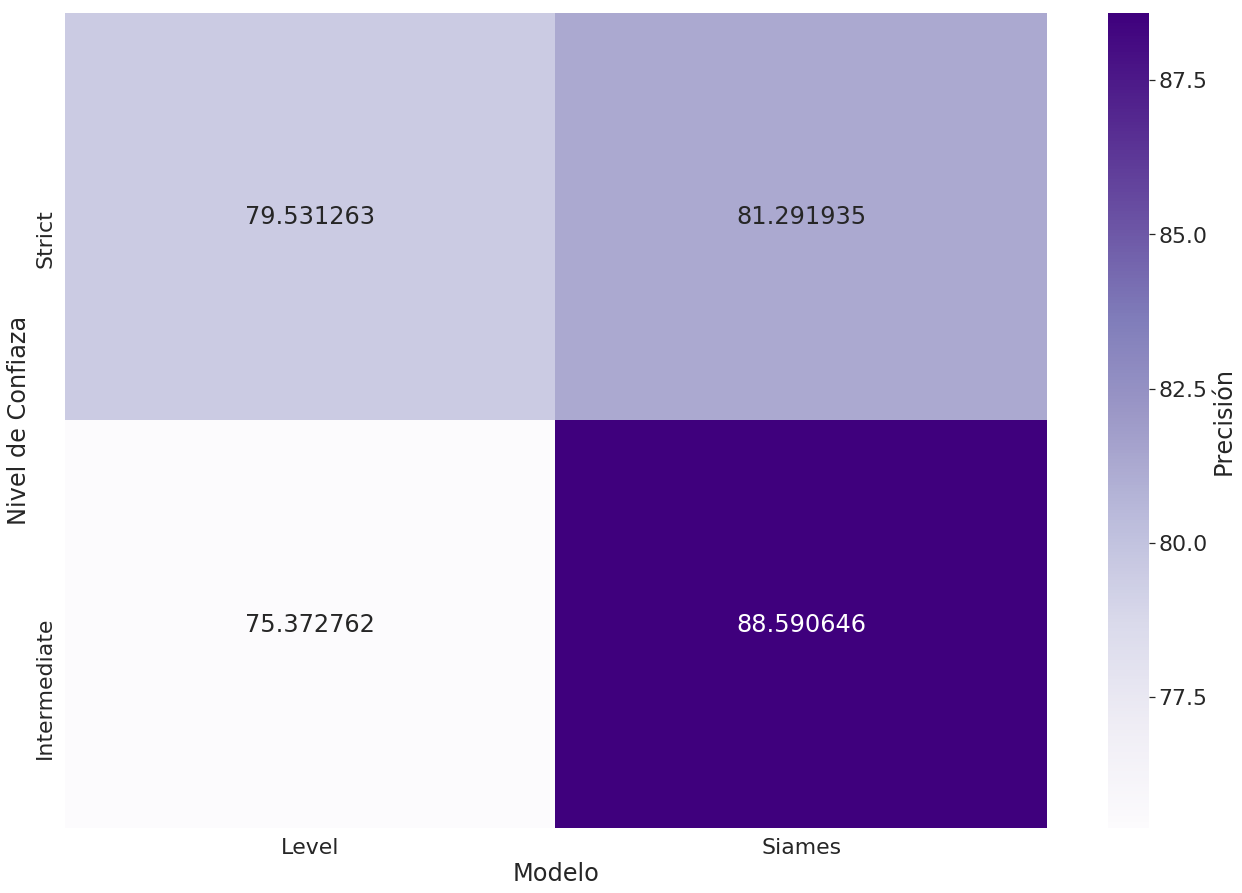

In [45]:
sns.set(font_scale=2)
plt.subplots(figsize=(22,15))
ax = sns.heatmap(matrix_models_mean*100,annot=True,fmt="f", cmap="Purples",square=False,xticklabels = ["Level","Siames"],yticklabels=["Strict","Intermediate"],cbar_kws={'label': 'Precisión'})
ax.set(ylabel='Nivel de Confiaza')
ax.set(xlabel='Modelo')
fig = ax.get_figure()
fig.savefig("paralogs_soft_precision2.png")

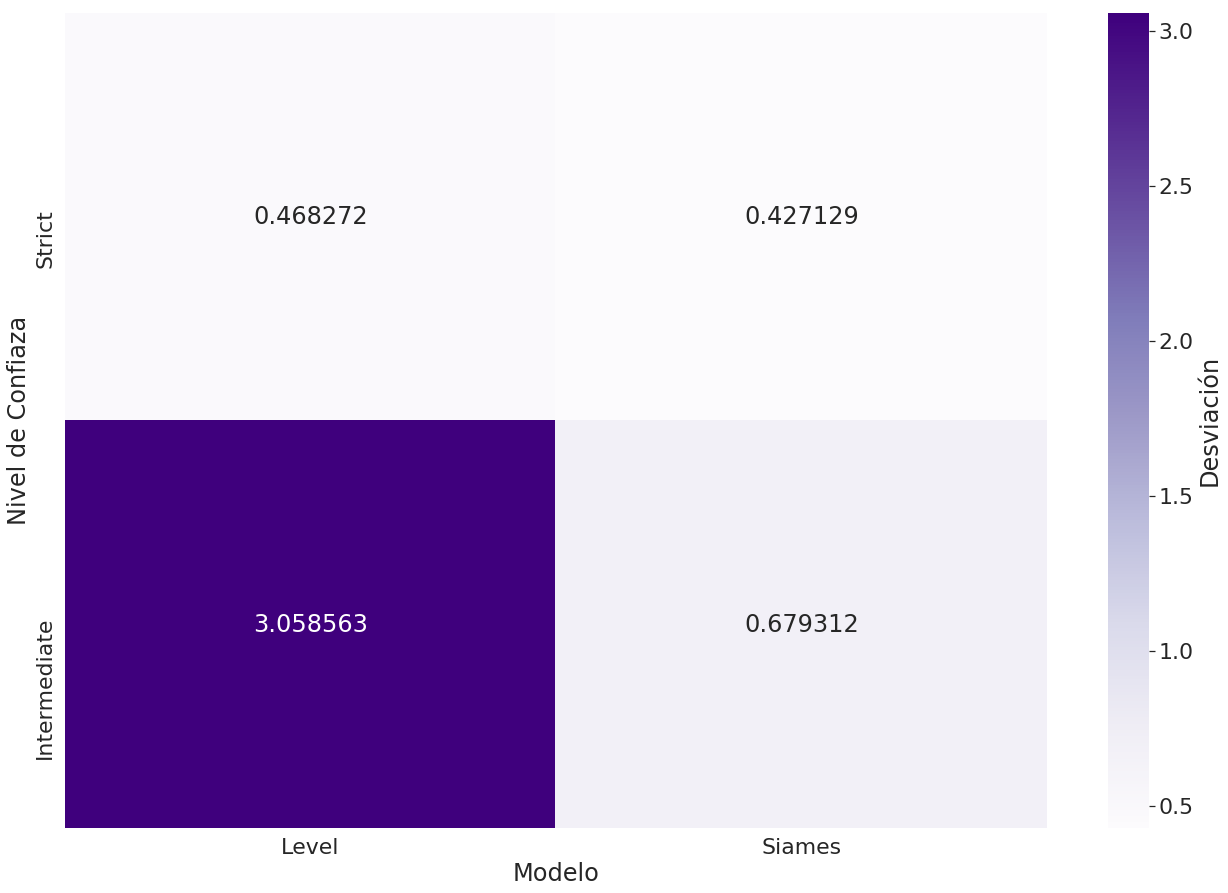

In [46]:
sns.set(font_scale=2)
plt.subplots(figsize=(22,15))
ax = sns.heatmap(matrix_models_std*100,annot=True,fmt="f", cmap="Purples",square=False,xticklabels = ["Level","Siames"],yticklabels=["Strict","Intermediate"],cbar_kws={'label': 'Desviación'})
ax.set(ylabel='Nivel de Confiaza')
ax.set(xlabel='Modelo')
fig = ax.get_figure()
fig.savefig("paralogs_soft_std2.png")

In [153]:
df_temp = pd.DataFrame(columns = ["Model Name","Level","Precision"])            
df_temp.head()
matrix_models_mean_list = [[[] for i in range(2)] for i in range(2)]
matrix_models_mean_list
i = 0
for level in levels:    
    working_level = level
    j = 0
    for modelName in modelNames_RNN_Binary:       
        log = get_log(generate_log_name(modelName,"complete",8,"cdna"))  
        matrix_models_mean_list[i][j] = np.asarray(log["val_main_acc"][-int(len(log["val_main_acc"])*0.2):])
        matrix_models_mean_list[i][j] = np.asarray(log["val_main_acc"][-int(len(log["val_main_acc"])*0.2):])                        
        j +=1        
    i +=1

In [154]:
i = 0
model_name_list = []
level_list = []
values_list = []
for level in levels: 
    j = 0
    for modelName in models_Second:       
        for k in range(0,30):
            model_name_list.append(modelName)
            level_list.append(level)           
            values_list.append(matrix_models_mean_list[i][j][k])                            
        j += 1    
    i += 1
    
df_temp["Model Name"] = model_name_list
df_temp["Level"] = level_list
df_temp["Precision"] = values_list
df_temp.head()

,Model Name,Level,Precision
0,Siames,Strict,0.858092
1,Siames,Strict,0.856668
2,Siames,Strict,0.858567
3,Siames,Strict,0.860228
4,Siames,Strict,0.852159


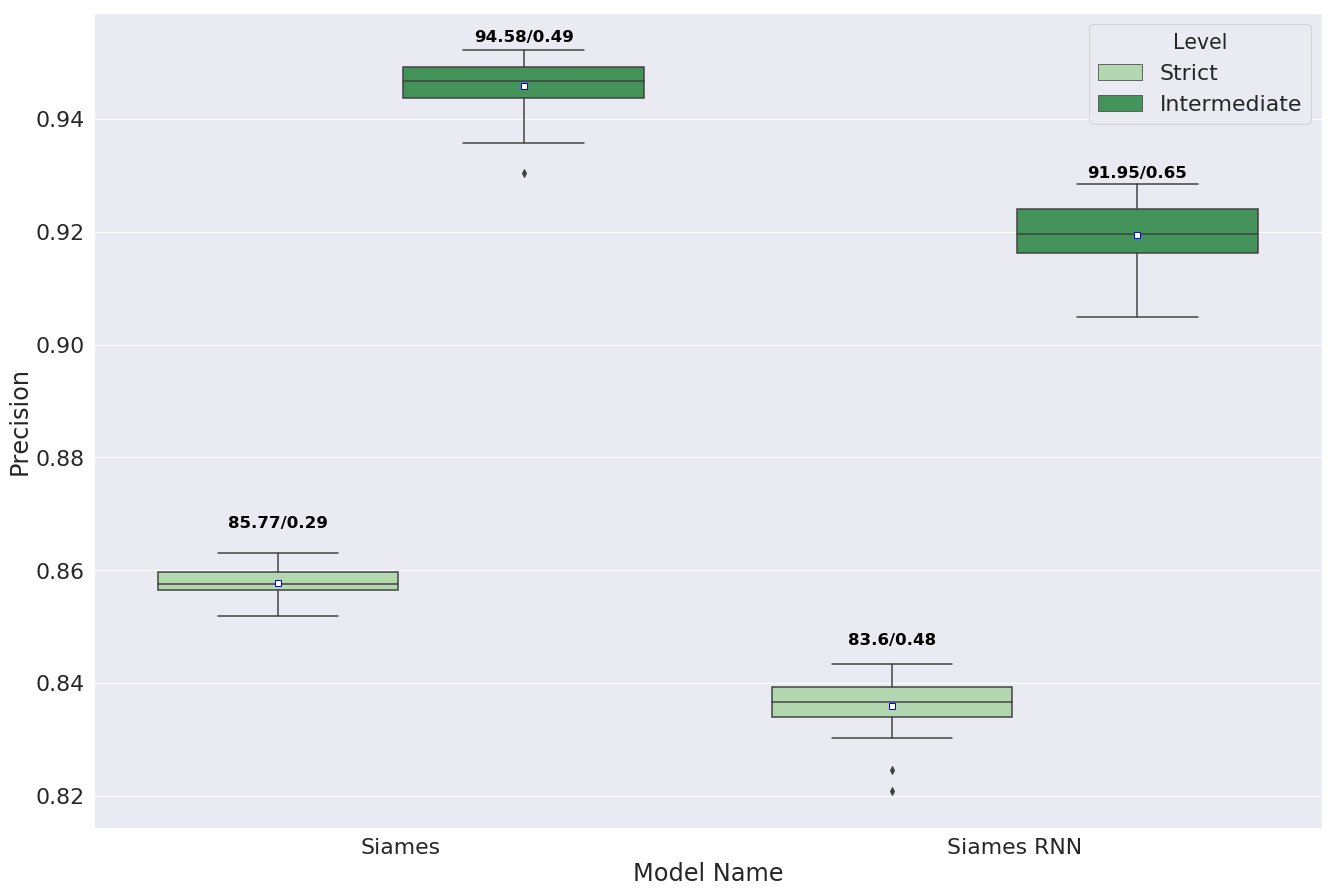

In [155]:
plt.subplots(figsize=(22,15))
ax = sns.boxplot("Model Name","Precision","Level",data=df_temp,showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"},palette="Greens")

std = df_temp.groupby(['Model Name',"Level"])['Precision'].std().values
mean = df_temp.groupby(['Model Name',"Level"])['Precision'].mean().values
median = df_temp.groupby(['Model Name',"Level"])['Precision'].median().values
labels = [str(np.round(m*100, 2)) + "/" + str(np.round(s*100, 2)) for (s,m) in zip(std,mean)]

pos = range(len(std))
for tick in pos:  
    if(tick % 2 == 0):
        if(tick == 0):
            ax.text(pos[tick]+ 0.2 - 0.5*pos[tick], median[tick]+0.007 , labels[tick], 
                horizontalalignment='center', size='x-small', color='black', weight='semibold')
        else:
            ax.text(pos[tick]+ 0.2 - 0.5*pos[tick], median[tick]+0.01, labels[tick], 
                horizontalalignment='center', size='x-small', color='black', weight='semibold')
        
    else:
        if(tick == 1):
            ax.text(pos[tick] - 0.7 - 0.5*pos[tick], median[tick]+0.01 , labels[tick], 
                horizontalalignment='center', size='x-small', color='black', weight='semibold')
        else:
            ax.text(pos[tick] - 0.7 - 0.5*pos[tick], median[tick]+0.01 , labels[tick], 
                horizontalalignment='center', size='x-small', color='black', weight='semibold')
fig = ax.get_figure()
fig.savefig("siames_RNN_binary_v2.png")

In [33]:
matrix_models_level_mean = np.ndarray(shape=(2,2))
matrix_models_level_std = np.ndarray(shape=(2,2))
i = 0
for level in levels:    
    working_level = level
    j = 0
    for modelName in modelNames_RNN_Binary:
        log = get_log(generate_log_name(modelName,"complete",8,"cdna"))
        matrix_models_mean[i,j] = np.mean(log["val_main_acc"][-int(len(log["val_aux_acc"])*0.2):])              
        matrix_models_std[i,j] = np.std(log["val_main_acc"][-int(len(log["val_aux_acc"])*0.2):])  
        j +=1                       
    i +=1
matrix_models_mean

array([[0.85760876, 0.83600696],
       [0.94574451, 0.91947502]])

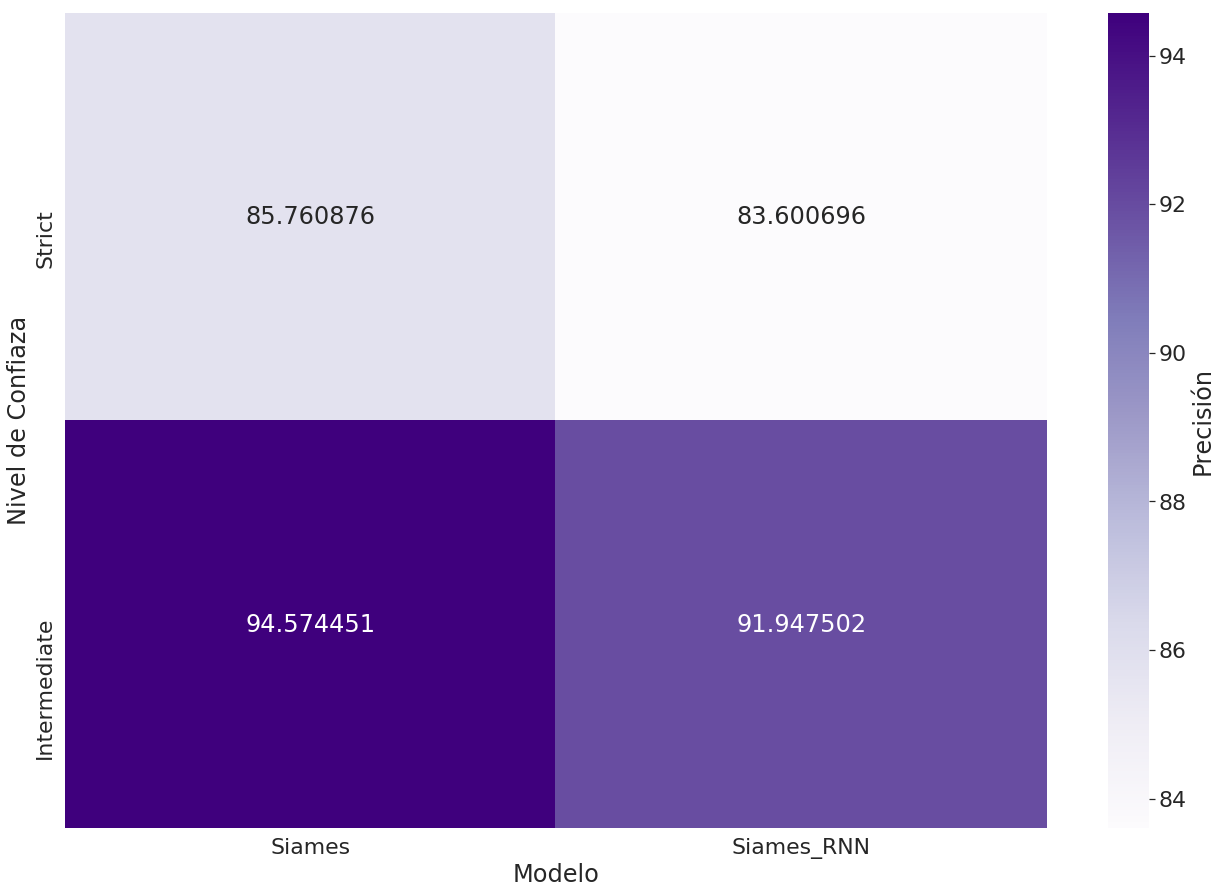

In [36]:
sns.set(font_scale=2)
plt.subplots(figsize=(22,15))
ax = sns.heatmap(matrix_models_mean*100,annot=True,fmt="f", cmap="Purples",square=False,xticklabels = ["Siames","Siames_RNN"],yticklabels=["Strict","Intermediate"],cbar_kws={'label': 'Precisión'})
ax.set(ylabel='Nivel de Confiaza')
ax.set(xlabel='Modelo')
fig = ax.get_figure()
#fig.savefig("paralogs_RNN_binary_precision2.png")

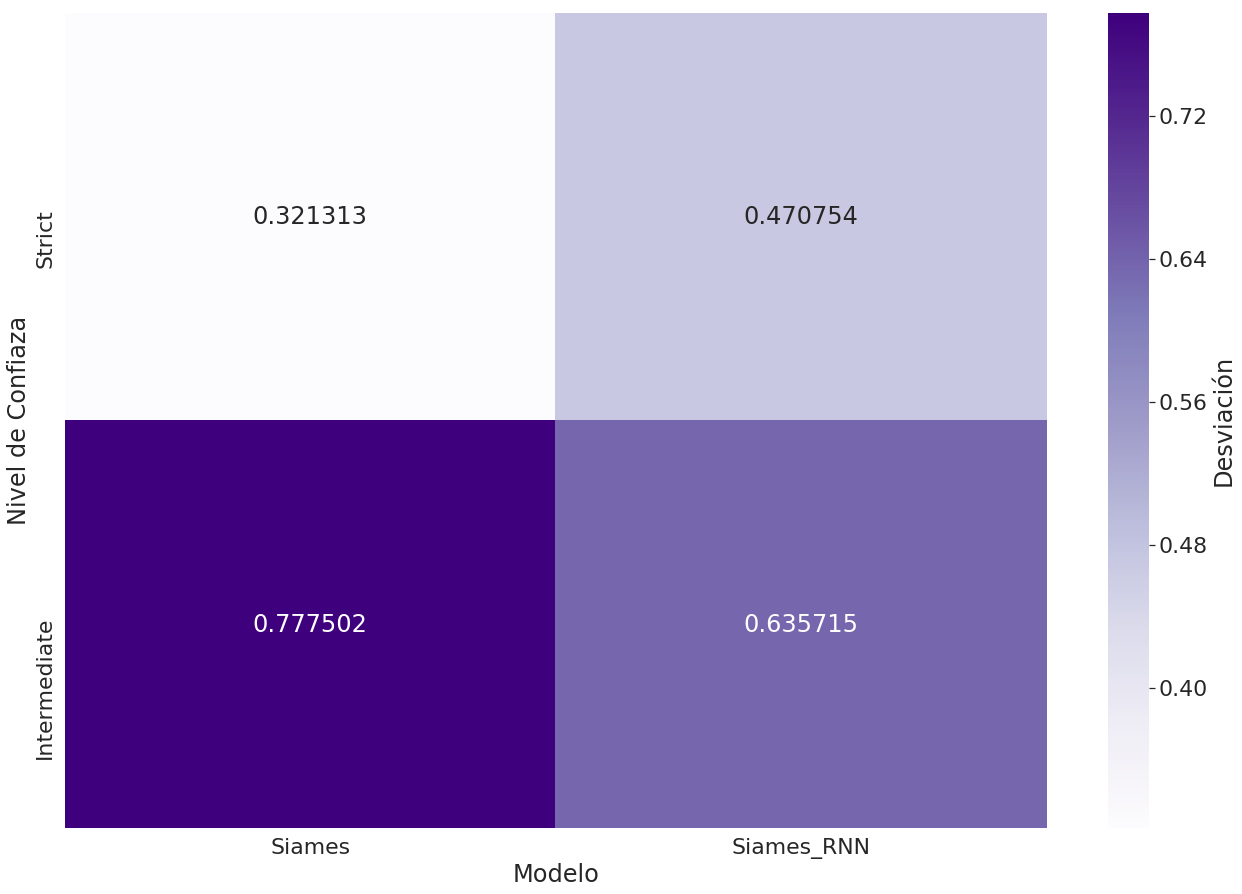

In [39]:
sns.set(font_scale=2)
plt.subplots(figsize=(22,15))
ax = sns.heatmap(matrix_models_std*100,annot=True,fmt="f", cmap="Purples",square=False,xticklabels = ["Siames","Siames_RNN"],yticklabels=["Strict","Intermediate"],cbar_kws={'label': 'Desviación'})
ax.set(ylabel='Nivel de Confiaza')
ax.set(xlabel='Modelo')
fig = ax.get_figure()
fig.savefig("paralogs_RNN_binary_std2.png")

In [156]:
df_temp = pd.DataFrame(columns = ["Model Name","Level","Precision"])            
df_temp.head()
matrix_models_mean_list = [[[] for i in range(2)] for i in range(2)]
matrix_models_mean_list
i = 0
for level in levels:    
    working_level = level
    j = 0
    for modelName in modelNames_RNN_Soft:       
        log = get_log(generate_log_name(modelName,"complete",8,"cdna"))  
        matrix_models_mean_list[i][j] = np.asarray(log["val_main_acc"][-int(len(log["val_main_acc"])*0.2):])
        matrix_models_mean_list[i][j] = np.asarray(log["val_main_acc"][-int(len(log["val_main_acc"])*0.2):])                        
        j +=1        
    i +=1

In [157]:
i = 0
model_name_list = []
level_list = []
values_list = []
for level in levels: 
    j = 0
    for modelName in models_Second:       
        for k in range(0,30):
            model_name_list.append(modelName)
            level_list.append(level)           
            values_list.append(matrix_models_mean_list[i][j][k])                            
        j += 1    
    i += 1
    
df_temp["Model Name"] = model_name_list
df_temp["Level"] = level_list
df_temp["Precision"] = values_list
df_temp.head()

,Model Name,Level,Precision
0,Siames,Strict,0.813063
1,Siames,Strict,0.820302
2,Siames,Strict,0.814189
3,Siames,Strict,0.814994
4,Siames,Strict,0.809202


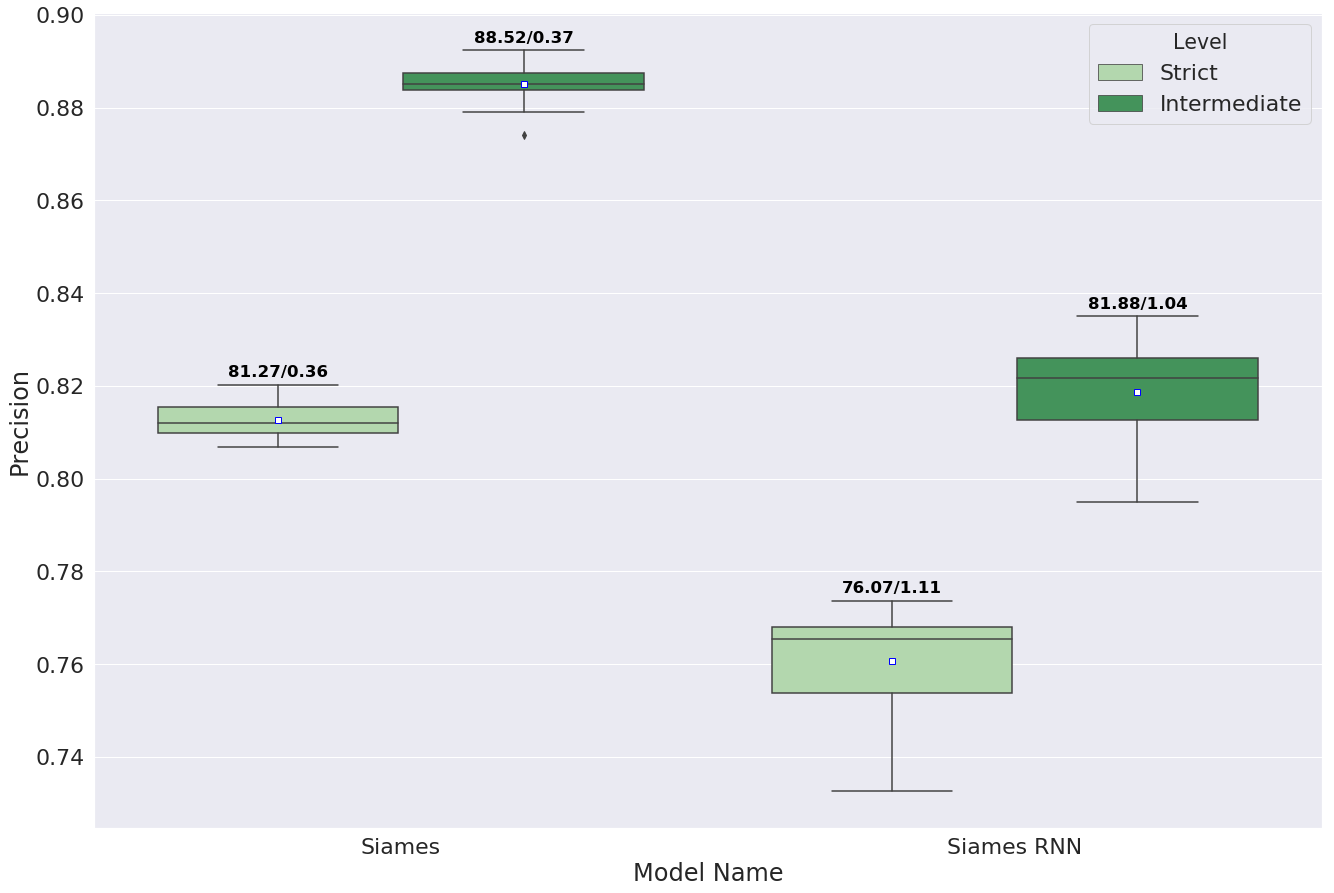

In [158]:
plt.subplots(figsize=(22,15))
ax = sns.boxplot("Model Name","Precision","Level",data=df_temp,showmeans=True,meanprops={"marker":"s","markerfacecolor":"white", "markeredgecolor":"blue"},palette="Greens")

std = df_temp.groupby(['Model Name',"Level"])['Precision'].std().values
mean = df_temp.groupby(['Model Name',"Level"])['Precision'].mean().values
median = df_temp.groupby(['Model Name',"Level"])['Precision'].median().values
labels = [str(np.round(m*100, 2)) + "/" + str(np.round(s*100, 2)) for (s,m) in zip(std,mean)]

pos = range(len(std))
for tick in pos:  
    if(tick % 2 == 0):
        if(tick == 0):
            ax.text(pos[tick]+ 0.2 - 0.5*pos[tick], median[tick]+0.009 , labels[tick], 
                horizontalalignment='center', size='x-small', color='black', weight='semibold')
        else:
            ax.text(pos[tick]+ 0.2 - 0.5*pos[tick], median[tick]+0.015, labels[tick], 
                horizontalalignment='center', size='x-small', color='black', weight='semibold')
        
    else:
        if(tick == 1):
            ax.text(pos[tick] - 0.7 - 0.5*pos[tick], median[tick]+0.01 , labels[tick], 
                horizontalalignment='center', size='x-small', color='black', weight='semibold')
        else:
            ax.text(pos[tick] - 0.7 - 0.5*pos[tick], median[tick]+0.01 , labels[tick], 
                horizontalalignment='center', size='x-small', color='black', weight='semibold')
fig = ax.get_figure()
fig.savefig("siames_RNN_soft_v2.png")

In [41]:
matrix_models_level_mean = np.ndarray(shape=(2,2))
matrix_models_level_std = np.ndarray(shape=(2,2))
i = 0
for level in levels:    
    working_level = level
    j = 0
    for modelName in modelNames_RNN_Soft:
        log = get_log(generate_log_name(modelName,"complete",8,"cdna"))
        matrix_models_mean[i,j] = np.mean(log["val_main_acc"][-int(len(log["val_aux_acc"])*0.2):])              
        matrix_models_std[i,j] = np.std(log["val_main_acc"][-int(len(log["val_aux_acc"])*0.2):])  
        j +=1                       
    i +=1
matrix_models_mean

array([[0.81291935, 0.76072501],
       [0.88590646, 0.81877267]])

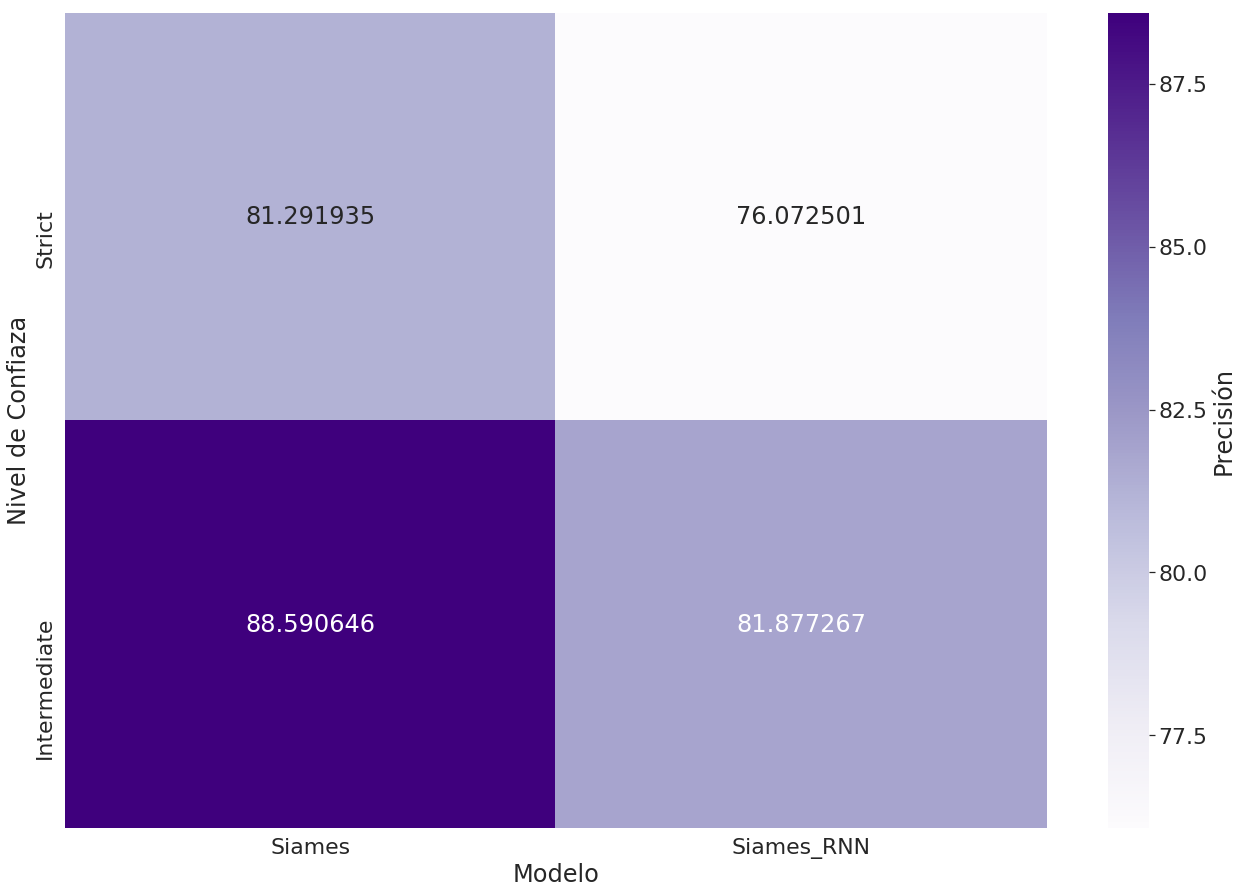

In [47]:
sns.set(font_scale=2)
plt.subplots(figsize=(22,15))
ax = sns.heatmap(matrix_models_mean*100,annot=True,fmt="f", cmap="Purples",square=False,xticklabels = ["Siames","Siames_RNN"],yticklabels=["Strict","Intermediate"],cbar_kws={'label': 'Precisión'})
ax.set(ylabel='Nivel de Confiaza')
ax.set(xlabel='Modelo')
fig = ax.get_figure()
#fig.savefig("paralogs_RNN_softmax_precision2.png")

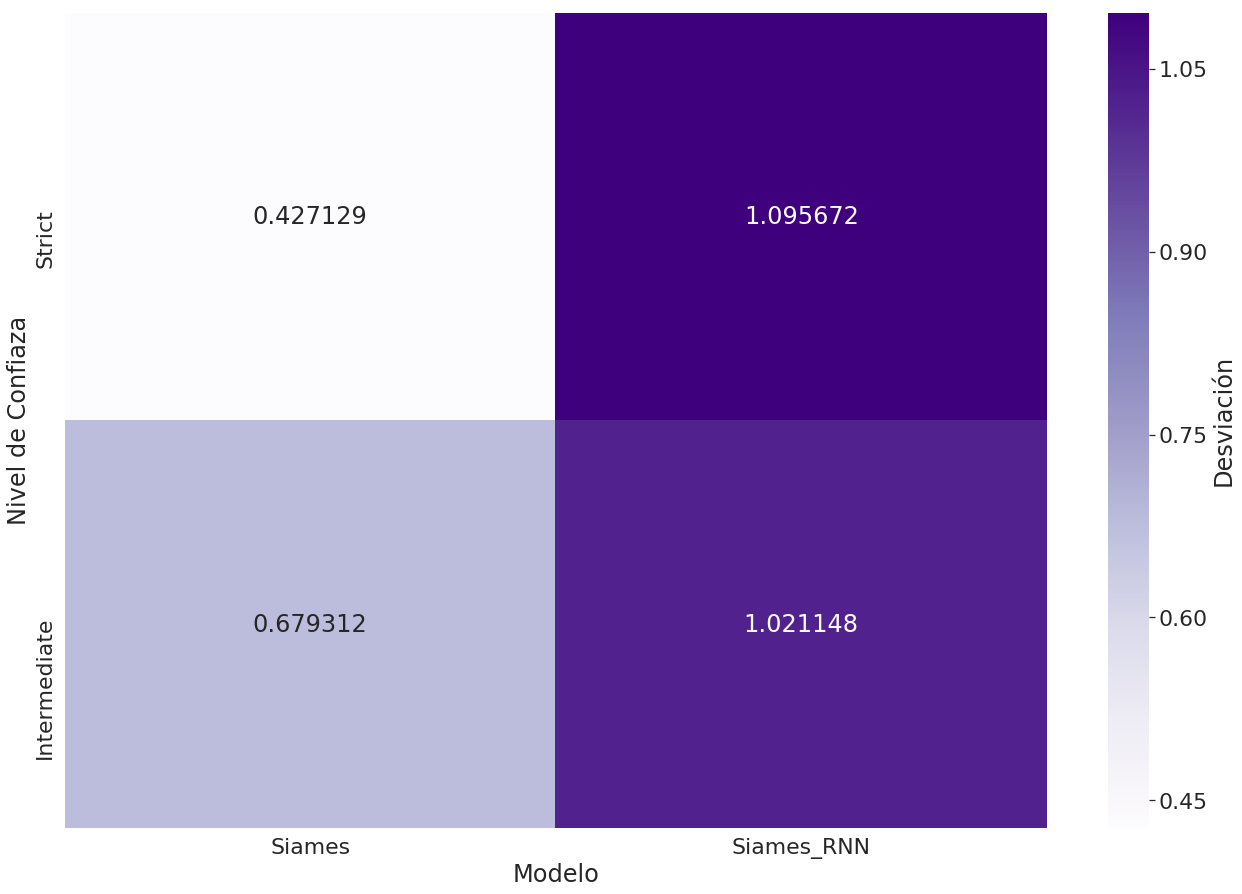

In [46]:
sns.set(font_scale=2)
plt.subplots(figsize=(22,15))
ax = sns.heatmap(matrix_models_std*100,annot=True,fmt="f", cmap="Purples",square=False,xticklabels = ["Siames","Siames_RNN"],yticklabels=["Strict","Intermediate"],cbar_kws={'label': 'Desviación'})
ax.set(ylabel='Nivel de Confiaza')
ax.set(xlabel='Modelo')
fig = ax.get_figure()
#fig.savefig("paralogs_RNN_soft_std2.png")

In [159]:
working_level = "Strict"
kmer_chosen = 8
type_chosen = "cdna"

dataset_complete = pd.read_pickle(train_filepath + working_level + "/datasets/2_paralog_dataset_complete-" + str(kmer_chosen) + "-" + type_chosen + ".pkl")
dataset_complete_soft = pd.read_pickle(train_filepath + working_level + "/datasets/3_paralog_dataset_complete-" + str(kmer_chosen) + "-" + type_chosen + ".pkl")

In [160]:
new_classes = []
for index, row in dataset_complete_soft.iterrows():
    if(row["Is_Ohnolog"] == 1):
        new_classes.append(1)
    else:
        if(row["Is_Paralog"] == 0):
            new_classes.append(0)
        else:
            new_classes.append(2)
dataset_complete_soft["Dup_Class"] = new_classes
dataset_complete_soft.head()

,Specie_Chicken,Specie_Dog,Specie_Human,Specie_Mouse,Specie_Pig,Specie_Rat,Is_Ohnolog,Is_Paralog,Sequence-1 GC,Sequence-1 Length,...,Embedding2_91,Embedding2_92,Embedding2_93,Embedding2_94,Embedding2_95,Embedding2_96,Embedding2_97,Embedding2_98,Embedding2_99,Dup_Class
0,0,0,1,0,0,0,1,0.0,0.429090,0.030467,...,35.407509,23.369914,8.144324,-26.702099,241.207709,-12.695194,-79.573883,121.379307,-69.633950,1
1,0,0,1,0,0,0,1,0.0,0.441268,0.053554,...,12.556002,23.217834,3.162621,-18.980361,204.830682,-20.962017,-61.163222,122.543777,-26.694989,1
2,0,0,1,0,0,0,1,0.0,0.357972,0.111632,...,-6.850837,12.314794,-3.387437,-5.403946,93.521862,4.187927,-35.880841,50.565405,-9.853733,1
3,0,0,1,0,0,0,1,0.0,0.684226,0.031676,...,68.287420,6.295047,37.820265,-33.841090,230.696114,-60.500167,-82.975793,174.224105,-111.569089,1
4,0,0,1,0,0,0,1,0.0,0.402629,0.018732,...,18.025175,13.675959,21.304353,-2.702105,162.972440,-8.209692,-46.736790,62.650600,-39.056701,1


In [161]:
blast_columns = ["Percent Identical Matches","Aligment Length","Nr Mismatch","Nr Gap Open","Evalue","Bit Score"]

e_values_columns = ["Evalue_Total","Evalue_High","Evalue_Medium","Evalue_Low"]

blast_types = ["High","Medium","Low","Total"]
blast_col_Total = [i + "_Total" for i in blast_columns] 
blast_col_High = [i + "_High" for i in blast_columns]
blast_col_Medium = [i + "_Medium" for i in blast_columns]
blast_col_Low = [i + "_Low" for i in blast_columns]

blast_cols_levels = blast_col_High + blast_col_Medium + blast_col_Low
total_columns = (blast_col_High + blast_col_Medium + blast_col_Low + blast_col_Total + ["Nr Hits"])

non_training_meta_features = ["Sequence-1","Sequence-2","Sequence-1 Id","Sequence-1-Transcript Id","Sequence-2 Id","Sequence-2-Transcript Id","Sequence-1-Transcript-Version","Sequence-2-Transcript-Version"]

sequence_1_metadata = ["Sequence-1 GC","Sequence-1 Length","Sequence-1-Chromosome","Seq-1-Biotype_protein_coding"]
sequence_2_metadata = ["Sequence-2 GC","Sequence-2 Length","Sequence-2-Chromosome","Seq-2-Biotype_protein_coding"]

sequence_1_metadata_diferential = ["Sequence-1 GC","Sequence-1 Length"]
sequence_2_metadata_diferential = ["Sequence-2 GC","Sequence-2 Length"]

sequence_1_metadata_categorical = ["Sequence-1-Chromosome","Seq-1-Biotype_protein_coding"]
sequence_2_metadata_categorical = ["Sequence-2-Chromosome","Seq-2-Biotype_protein_coding"]

species_metadata = ["Specie_Chicken","Specie_Dog","Specie_Human","Specie_Mouse","Specie_Pig","Specie_Rat"]

emb_size = 100
if(type_chosen == "cdna2"):
    emb_size = 200
embedding_1_cols = ["Embedding1_" + str(i) for i in range(0,emb_size)]
embedding_2_cols = ["Embedding2_" + str(i) for i in range(0,emb_size)]

In [162]:
def get_train_val_test(df):
    df.sample(frac=1,random_state=7)
    df_train, df_test = train_test_split(df, test_size=0.2,random_state=9,stratify=df["Is_Ohnolog"])
    df_train, df_val = train_test_split(df_train, test_size=0.2,random_state=3,stratify=df_train["Is_Ohnolog"])
    return (df_train,df_val,df_test)

In [163]:
def get_train_val_test_soft(df):
    df.sample(frac=1,random_state=7)
    df_train, df_test = train_test_split(df, test_size=0.2,random_state=9,stratify=df["Dup_Class"])
    df_train, df_val = train_test_split(df_train, test_size=0.2,random_state=3,stratify=df_train["Dup_Class"])
    return (df_train,df_val,df_test)

In [164]:
def get_log(name):
     return json.load(open(train_filepath + working_level + "/model_run_history/" + name + ".json", 'r'))

In [165]:
import keras.backend as K
from keras.layers import Lambda

def get_tensor_embedding_layer(input_embedding):    
    emb_x = Dense(512, activation='elu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(input_embedding)       
    emb_x = BatchNormalization()(emb_x)
    emb_x = Dropout(0.4)(emb_x)    
    emb_x = Dense(256,use_bias = False, activation='elu',kernel_regularizer=regularizers.l1(0.0005))(emb_x)            
    emb_x = BatchNormalization()(emb_x)    
    emb_x = Dropout(0.4)(emb_x)    
    emb_x = Dense(128,use_bias = False, activation='elu',kernel_regularizer=regularizers.l1(0.0005))(emb_x)            
    emb_x = BatchNormalization()(emb_x)    
    emb_x = Dense(64, use_bias = False, activation='elu',kernel_regularizer=regularizers.l1(0.0005))(emb_x)            
    emb_x = BatchNormalization()(emb_x)    
    emb_x = Dense(32, use_bias = False, activation='elu',kernel_regularizer=regularizers.l1(0.0005))(emb_x)                
    emb_x = BatchNormalization()(emb_x)    
    return emb_x

def level_siames_merge_layer(df_meta_input,df_embeddings_1,df_embeddings_2,name,bs):    
    
    input_embedding_1 = Input(shape=(len(df_embeddings_1.columns),), name='embedding_input_1')        
    input_embedding_2 = Input(shape=(len(df_embeddings_2.columns),), name='embedding_input_2')        
    
    emb_x_1 = get_tensor_embedding_layer(input_embedding_1)    
    emb_x_2 = get_tensor_embedding_layer(input_embedding_2)    
    
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([emb_x_1, emb_x_2])
    
    emb_x_out = Dense(3, activation='softmax',name="aux")(L1_distance)                
    
    meta_input = Input(shape=(len(df_meta_input.columns),), name='meta_input')    
    
    x = keras.layers.concatenate([L1_distance,meta_input])
    x = Dense(128, activation='relu',use_bias=False)(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)   
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.001))(x)    
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(16, activation='relu',kernel_regularizer=regularizers.l2(0.0005))(x)    
    x = Dropout(0.1)(x)
    x = Dense(8, activation='relu',use_bias=False,kernel_regularizer=regularizers.l2(0.0005))(x)
    x = BatchNormalization()(x)
    predictions = Dense(3, activation='softmax',name="main")(x)
        
    model_created = Model(inputs=[input_embedding_1,input_embedding_2,meta_input], outputs=[predictions,emb_x_out])
    model_created.Name = name
    return model_created


In [166]:
df_train,df_val,df_test = get_train_val_test_soft(dataset_complete_soft)

In [167]:
df_train_x = df_train.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_train_x = df_train_x.drop(embedding_1_cols,axis=1)
df_train_x = df_train_x.drop(embedding_2_cols,axis=1)

df_train_emb_x_1 = df_train[embedding_1_cols]
df_train_emb_x_2 = df_train[embedding_2_cols]
df_train_y = df_train["Dup_Class"]

df_val_x = df_val.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_val_x = df_val_x.drop(embedding_1_cols,axis=1)
df_val_x = df_val_x.drop(embedding_2_cols,axis=1)

df_val_emb_x_1 = df_val[embedding_1_cols]
df_val_emb_x_2 = df_val[embedding_2_cols]                  
df_val_y = df_val["Dup_Class"]

df_test_x = df_test.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"],axis=1)
df_test_x = df_test_x.drop(embedding_1_cols,axis=1)
df_test_x = df_test_x.drop(embedding_2_cols,axis=1)

df_test_emb_x_1 =  df_test[embedding_1_cols]
df_test_emb_x_2 =  df_test[embedding_2_cols]
df_test_y = df_test["Dup_Class"]

In [168]:
df_complete_final = df_test

In [173]:
board_dir = train_filepath + "Strict" + "/model_checkpoints/"

In [174]:
siames_softmax =  level_siames_merge_layer(df_complete_final.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"] + embedding_1_cols + embedding_2_cols,axis=1),df_complete_final[embedding_1_cols],df_complete_final[embedding_2_cols],"model_1",128)
siames_softmax.load_weights(board_dir + "Siames_Softmax.hdf5")
siames_softmax.compile(optimizer=Adamax(),loss='sparse_categorical_crossentropy',metrics=['accuracy',km.sparse_categorical_recall()])

In [202]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    
    heatmap = sns.heatmap(df_cm, annot=True, fmt=".2f",cmap="Greens",cbar_kws={'label': 'Porcentaje'})
    
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Clase Verdadera')
    plt.xlabel('Clase Predecida')
    return heatmap

In [78]:
siames_softmax.evaluate([df_complete_final[embedding_1_cols] ,df_complete_final[embedding_2_cols],df_complete_final.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"] + embedding_1_cols + embedding_2_cols,axis=1)],[df_complete_final["Dup_Class"],df_complete_final["Dup_Class"]])

7770/7770 [==============================] - 1s 186us/step


[1.5698084010734215,
 0.49478758693201663,
 0.9592947006992698,
 0.8059202059508904,
 0.637488106553045,
 0.4965250965250965,
 0.6361560418527848]

In [76]:
siames_softmax.metrics_names

['loss',
 'main_loss',
 'aux_loss',
 'main_acc',
 'main_recall',
 'aux_acc',
 'aux_recall']

In [176]:
predict = siames_softmax.predict([df_complete_final[embedding_1_cols] ,df_complete_final[embedding_2_cols],df_complete_final.drop(["Is_Ohnolog","Is_Paralog","Dup_Class"] + embedding_1_cols + embedding_2_cols,axis=1)])

In [82]:
predict

[array([[1.5910888e-02, 1.3021076e-01, 8.5387838e-01],
        [5.5719553e-03, 8.9885604e-01, 9.5572054e-02],
        [9.9998999e-01, 3.8623753e-06, 6.1649871e-06],
        ...,
        [9.9990141e-01, 3.6963658e-05, 6.1682731e-05],
        [9.9915409e-01, 4.2056487e-04, 4.2538519e-04],
        [6.7694604e-02, 8.0359869e-02, 8.5194552e-01]], dtype=float32),
 array([[0.09932036, 0.2669404 , 0.6337393 ],
        [0.20845379, 0.38339278, 0.40815344],
        [0.6340365 , 0.18154755, 0.18441592],
        ...,
        [0.47342455, 0.3423676 , 0.18420786],
        [0.9004944 , 0.0853597 , 0.01414595],
        [0.20281759, 0.25729287, 0.5398896 ]], dtype=float32)]

In [177]:
predict_class = np.argmax(predict[0], axis=1)
predict_class = predict_class.tolist()

In [178]:
df_complete_final["Dup_Class"].values

array([2, 1, 0, ..., 0, 0, 0])

In [194]:
confusion_matrix_1 = confusion_matrix(df_complete_final["Dup_Class"].values,predict_class)

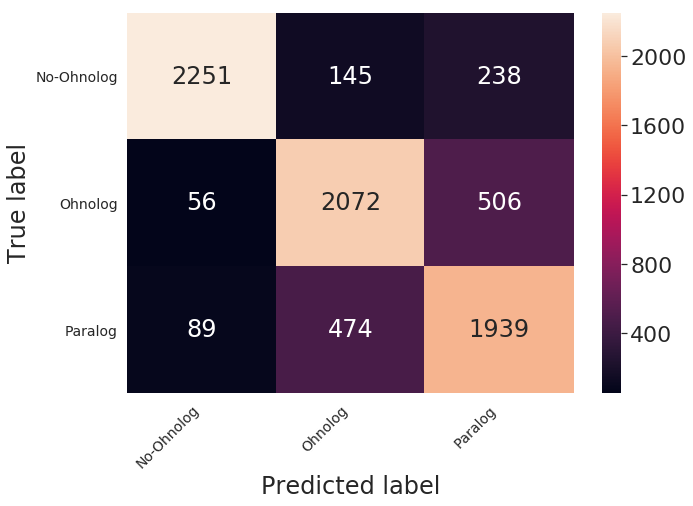

In [95]:
ax = print_confusion_matrix(confusion_matrix,["No-Ohnolog","Ohnolog","Paralog"])

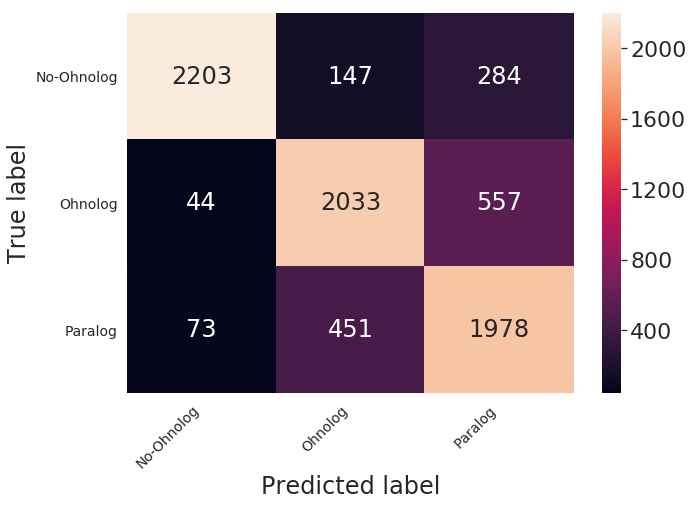

In [180]:
ax = print_confusion_matrix(confusion_matrix_1,["No-Ohnolog","Ohnolog","Paralog"])

In [195]:
confusion_matrix_1 = (confusion_matrix_1/2634)*100

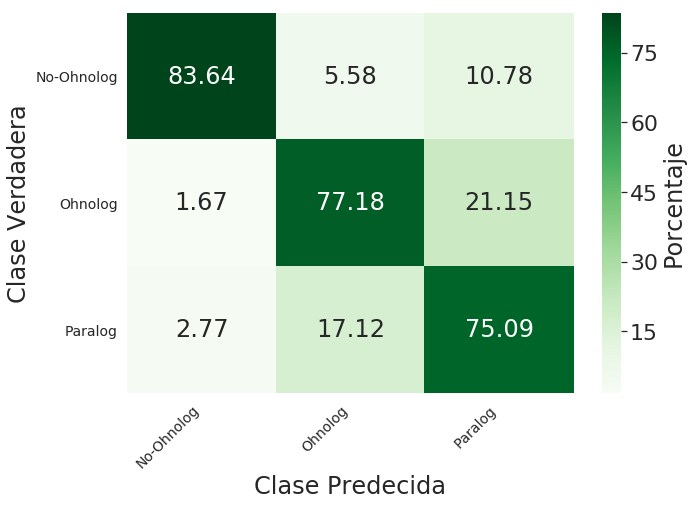

In [203]:
ax = print_confusion_matrix(confusion_matrix_1,["No-Ohnolog","Ohnolog","Paralog"])

In [204]:
fig = ax.get_figure()
fig.savefig("conf_matrix_v2.png")